In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

IndentationError: unindent does not match any outer indentation level (torch_fwrf.py, line 610)

In [4]:
device = torch.device('cpu:0')

In [20]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [13]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
# timestamp = 'May-03-2021_0134'
# timestamp = 'May-04-2021_0340'
# timestamp = 'May-09-2021_2309'
# timestamp = 'May-10-2021_1849'
timestamp = 'May-16-2021_1422'
# timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

In [15]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
fns = [fn for fn in fns if 'model_params' in fn]
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

['model_params_allROIs']
dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'covar_each_model_training', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'debug'])


In [16]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
covar_each_model_training = out['covar_each_model_training']
                                    
zscore_features = out['zscore_features']
# nonlin_fn = out['normalize_fn']
nonlin_fn = out['nonlin_fn']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

(11694, 3)
(11694, 432)


In [276]:
# Getting actual data to test with (slow)

subject = 1
root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

from src.load_nsd import image_uncolorize_fn, data_split, load_betas

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'    
beta_root = nsd_root + "nsddata_betas/ppdata/"
up_to_sess = 3

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
    
### LOADING DATA ####
print('Loading data for sessions 1:%d...'%up_to_sess)
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=up_to_sess, load_ext=".nii")
print('\nSize of full data set [nTrials x nVoxels] is:')
print(voxel_data.shape)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

data_size, n_voxels = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), voxel_data, ordering, imagewise=False)
n_trials_val = val_stim_single_trial_data.shape[0]
print(n_trials_val)

Loading data for sessions 1:3...
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.271, <sigma> = 1.348
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.136, <sigma> = 1.238
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.332, <sigma> = 1.340

Size of full data set [nTrials x nVoxels] is:
(2250, 11694)
Total number of voxels = 11694
201


In [277]:
### DEFINE THE FILTERS FOR THE MODEL ###
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
n_ori=36
n_sf=12

print('\nBuilding Gabor filter bank with %d orientations and %d spatial frequencies...'%(n_ori, n_sf))
cyc_per_stim = logspace(n_sf)(3., 72.) # Which SF values are we sampling here?
_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer


Building Gabor filter bank with 36 orientations and 12 spatial frequencies...


In [278]:
### PARAMS FOR THE RF CENTERS, SIZES ####
aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

# models is three columns, x, y, sigma
models = model_space_pyramid(logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)    


In [371]:
min_pct_var=99
sample_batch_size = 10
voxel_batch_size=12
holdout_pct = 0.10
# holdout_size = int(np.ceil(np.shape(trn_voxel_data)[0]*holdout_pct))
debug=True
zscore_features=True

import gc
gc.collect()
torch.cuda.empty_cache()
nvox2use = 100
trials2use = 120
holdout_size = int(np.ceil(trials2use*holdout_pct))
best_losses, pc, best_params = learn_params_pca(
    trn_stim_data[0:trials2use,:], trn_voxel_data[0:trials2use,0:nvox2use], _fmaps_fn, models, min_pct_var=min_pct_var, \
    aperture=aperture, zscore=zscore_features, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True, debug=debug)
pca_wts = pc[0]
pct_var_expl = pc[1]
n_comp_needed = pc[3]
pca_pre_mean = pc[4]

best_model_inds = best_params[5]
print('\nDone with training\n')

trn_size = 108 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------



/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



x=-0.6, y=-0.6, sigma=0.0: retaining 39 components to expl 99 pct var

fitting model    0 of 875 , voxels [    96:99    ] of 100

/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



x=-0.5, y=-0.6, sigma=0.0: retaining 37 components to expl 99 pct var

fitting model    1 of 875 , voxels [    96:99    ] of 100
---------------------------------------
total time = 1.712437s
total throughput = 0.017124s/voxel
voxel throughput = 0.000335s/voxel
setup throughput = 0.001919s/model

Done with training



In [336]:
np.shape(pca_wts)


(432, 432, 875)

In [356]:
weightseachvoxel = best_params[1]
biaseseachvoxel = best_params[2]
meaneachvoxel = best_params[3]
stdeachvoxel = best_params[4]
ncompeachvoxel = pc[3][best_params[5]]

for vidx in range(2):
    
    print([ weightseachvoxel[vidx,int(ncompeachvoxel[vidx])-1], weightseachvoxel[vidx,int(ncompeachvoxel[vidx])], weightseachvoxel[vidx,-1], biaseseachvoxel[vidx]])
    print([ meaneachvoxel[vidx,int(ncompeachvoxel[vidx])-1], meaneachvoxel[vidx,int(ncompeachvoxel[vidx])], meaneachvoxel[vidx,-1]])
    print([ stdeachvoxel[vidx,int(ncompeachvoxel[vidx])-1], stdeachvoxel[vidx,int(ncompeachvoxel[vidx])], stdeachvoxel[vidx,-1]])
    print('\n')


[-0.057617404, 0.0, 0.0, 0.12666872]
[-7.275958e-12, 0.0, 0.0]
[0.00029101665, 0.0, 0.0]


[-0.21696144, 0.0, 0.0, -0.26968598]
[-7.275958e-12, 0.0, 0.0]
[0.00029101665, 0.0, 0.0]




In [372]:
#### EVALUATE PERFORMANCE ON VALIDATION SET #####
gc.collect()
torch.cuda.empty_cache()
print('\nInitializing model for validation...\n')
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
trials2use = 108
# To initialize this module for prediction, need to take just first batch of voxels.
# Will eventually pass all voxels through in batches.
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, input_shape=trn_stim_data[0:trials2use,:].shape, aperture=1.0, pc=pc)
# _fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, input_shape=val_stim_single_trial_data.shape, aperture=1.0, pc=pc)

print('\nGetting model predictions on validation set...\n')
val_voxel_pred = get_predictions(trn_stim_data[0:trials2use,:], _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)
# val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)


Initializing model for validation...

Making fwrf module...


/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Getting model predictions on validation set...

samples [  100:107  ] of 108, voxels [    96:99    ] of 100
---------------------------------------
total time = 8.540096s
sample throughput = 0.079075s/sample
voxel throughput = 0.085401s/voxel


In [373]:
from src.torch_fwrf import get_r2

# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
val_cc  = np.zeros(shape=(n_voxels), dtype=fpX)
val_r2 = np.zeros(shape=(n_voxels), dtype=fpX)

print('\nEvaluating correlation coefficient on validation set...\n')
# for v in tqdm(range(n_voxels)): 
for v in tqdm(range(nvox2use)):
    val_cc[v] = np.corrcoef(trn_voxel_data[0:trials2use,v], val_voxel_pred[:,v])[0,1]  
    val_r2[v] = get_r2(trn_voxel_data[0:trials2use,v], val_voxel_pred[:,v])

#     val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
#     val_r2[v] = get_r2(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])

val_cc = np.nan_to_num(val_cc)
val_r2 = np.nan_to_num(val_r2)

100%|██████████| 100/100 [00:00<00:00, 4053.68it/s]


Evaluating correlation coefficient on validation set...



In [374]:
val_r2

array([0.3265677 , 0.45347923, 0.29449332, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

0.5294943


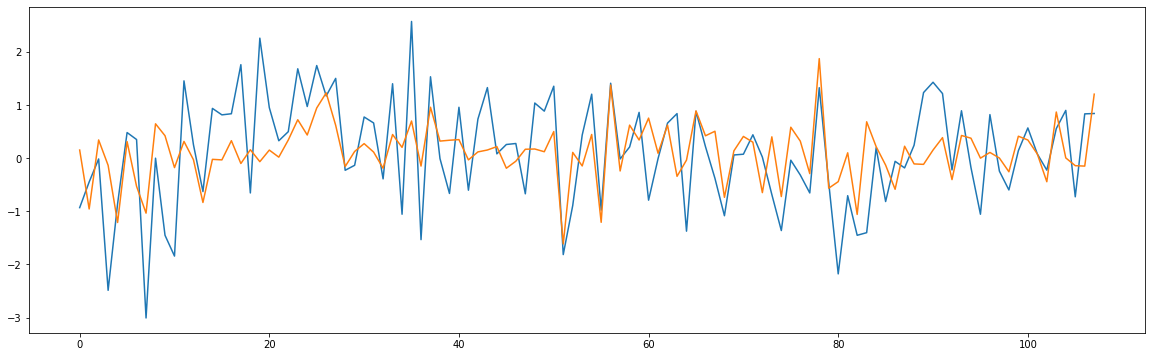

In [375]:
plt.figure(figsize=(20,6));
vidx=90

plt.plot(trn_voxel_data[0:trials2use,vidx])
# plt.plot(val_voxel_single_trial_data[0:trials2use,vidx])
plt.plot(val_voxel_pred[:,vidx])
print(val_cc[vidx])

In [376]:
### GET ACTUAL FEATURE VALUES FOR EACH TRIAL IN TESTING SET ########
# will use to compute tuning etc based on voxel responses in validation set.
# looping over every model here; there are fewer models than voxels so this is faster than doing each voxel separately.

## Testing this on the TRAINING set here, just to make sure that we get the exact expected outcome, sanity check.
dat2use = trn_voxel_data[0:trials2use,:]
n_trials_val = np.shape(dat2use)[0]
ims2use = trn_stim_data[0:trials2use]

print('\nComputing activation in each feature channel on validation set trials...\n')
n_features = best_params[1].shape[1]
n_prfs = models.shape[0]
features_each_model_val = np.zeros(shape=(n_trials_val, n_features, n_prfs),dtype=fpX)
features_pca_each_model_val = np.zeros(shape=(n_trials_val, n_features, n_prfs),dtype=fpX)

for mm in range(n_prfs):
    if debug and mm>1:
        break 
    sys.stdout.write('\rmodel %d of %d'%(mm,n_prfs))

    features = get_features_in_prf(models[mm,:], _fmaps_fn, ims2use, sample_batch_size, aperture, device) 
#     features = get_features_in_prf(models[mm,:], _fmaps_fn, val_stim_single_trial_data, sample_batch_size, aperture, device) 
    features_each_model_val[:,:,mm] = features
    
    # project into pca space
    features_submean = features - np.tile(np.expand_dims(pca_pre_mean[:,mm], axis=0), [np.shape(features)[0], 1])
    features_reduced = features_submean @ np.transpose(pca_wts[0:n_comp_needed[mm],:,mm]) # subtract mean in same way as for original training set features                                                       
    features_pca_each_model_val[:,0:n_comp_needed[mm],mm] = features_reduced[:,0:n_comp_needed[mm]] # multiply by weight matrix
    

### COMPUTE CORRELATION OF VALIDATION SET VOXEL RESP WITH FEATURE ACTIVATIONS ###########
# this will serve as a measure of "tuning"
print('\nComputing voxel/feature correlations for validation set trials...\n')
voxel_feature_correlations_val = np.zeros((n_voxels, n_features),dtype=fpX)
voxel_pca_feature_correlations_val = np.zeros((n_voxels, n_features),dtype=fpX)
best_models = best_params[0]

for vv in range(n_voxels):
    if debug and vv>1:
        break 
    sys.stdout.write('\rvoxel %d of %d'%(vv,n_voxels))

    # figure out for this voxel, which pRF estimate was best.
    best_model_ind = best_model_inds[vv]

    # taking features for the validation set images, within this voxel's fitted RF
    features2use = features_each_model_val[:,:,best_model_ind]
    features2use_pca = features_pca_each_model_val[:,:,best_model_ind]
                                                       
    for ff in range(n_features):        
        voxel_feature_correlations_val[vv,ff] = np.corrcoef(features2use[:,ff], dat2use[:,vv])[0,1]
#         voxel_feature_correlations_val[vv,ff] = np.corrcoef(features2use[:,ff], val_voxel_single_trial_data[:,vv])[0,1]
        if ff<n_comp_needed[best_model_ind]:                                               
            voxel_pca_feature_correlations_val[vv,ff] = np.corrcoef(features2use_pca[:,ff], dat2use[:,vv])[0,1]
#             voxel_pca_feature_correlations_val[vv,ff] = np.corrcoef(features2use_pca[:,ff], val_voxel_single_trial_data[:,vv])[0,1]
        else:
            voxel_pca_feature_correlations_val[vv,ff] = None                                        


Computing activation in each feature channel on validation set trials...

model 0 of 875

/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


model 1 of 875
Computing voxel/feature correlations for validation set trials...

voxel 1 of 11694

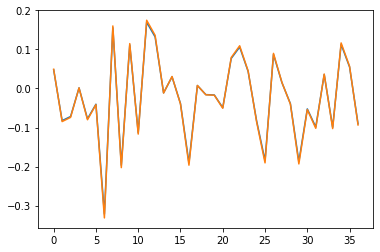

In [377]:
plt.figure();
vidx=1
wts = best_params[1]
plt.plot(voxel_pca_feature_correlations_val[vidx,:])
plt.plot(wts[vidx,0:n_comp_needed[best_model_inds[vidx]]])

In [158]:
def set_value(_x, x):

    if list(x.shape)!=list(_x.size()):
        _x.resize_(x.shape)
    _x.data.copy_(torch.from_numpy(x))
    

In [378]:
# Testing fitting code w PCA
import torch.nn as nn
from sklearn import decomposition
from src.torch_fwrf import get_fmaps_sizes, get_features_in_prf, _to_torch, _cofactor_fn_cpu, _loss_fn, get_value, set_value
from src.numpy_utility import iterate_range

def learn_params_pca(images, voxel_data, _fmaps_fn, models, min_pct_var = 99, aperture=1.0, zscore=False, sample_batch_size=100, voxel_batch_size=100, holdout_size=100, shuffle=True, add_bias=False, debug=False):
    """
    
    Learn the parameters of the model, using PCA first to decorrelate features.
    
    """
    
    pca = decomposition.PCA()

    dtype = images.dtype.type
    device = next(_fmaps_fn.parameters()).device
    trn_size = len(voxel_data) - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    print ('dtype = %s' % dtype)
    print ('device = %s' % device)
    print ('---------------------------------------')
       
    n_trials = len(images)
    n_prfs = len(models)
    n_voxels = voxel_data.shape[1]   
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        np.random.shuffle(order)
    images = images[order]
    voxel_data = voxel_data[order]  
    trn_data = voxel_data[:trn_size]
    out_data = voxel_data[trn_size:]
    
    # Looping over the feature maps once with a batch of images, to get their sizes
    n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, images[0:sample_batch_size], device)
    
    # Create full model value buffers    
    best_models = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)   
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels), dtype=dtype)
    best_w_params = np.zeros(shape=(n_voxels, n_features ), dtype=dtype)

    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
    features_mean = None
    features_std = None
    if zscore:
        features_mean = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
        features_std  = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
       
    # will save pca stuff as well
    pca_wts = np.zeros(shape=(n_features, n_features, n_prfs), dtype=dtype) # will be [ncomponents x nfeatures x nmodels]
    pca_pre_mean = np.zeros(shape=(n_features, n_prfs), dtype=dtype)
    pct_var_expl = np.zeros(shape=(n_features, n_prfs), dtype=dtype)
    n_comp_needed = np.zeros(shape=(n_prfs), dtype=np.int)
    
    start_time = time.time()
    vox_loop_time = 0
    print ('')
    
    with torch.no_grad():
        
        # Looping over models (here models are different spatial RF definitions)
        for m,(x,y,sigma) in enumerate(models):
            if debug and m>1:
                break

            t = time.time()            
            # Get features for the desired pRF, across all trn set image            
            features = get_features_in_prf((x,y,sigma), _fmaps_fn, images, sample_batch_size, aperture, device)     
            elapsed = time.time() - t

            # separate design matrix into training/held out data (for lambda selection)
            trn_features = features[:trn_size]
            out_features = features[trn_size:]   

            # Perform PCA to decorrelate feats and reduce dimensionality
            pca.fit(trn_features)
            trn_scores = pca.transform(trn_features)
            out_scores = pca.transform(out_features)
            wts = pca.components_
            ev = pca.explained_variance_
            ev = ev/np.sum(ev)*100
            pca_wts[0:len(ev),:,m] = wts # save a record of the transformation to interpret encoding model weights later [ncomponents x nfeatures]
            pca_pre_mean[:,m] = pca.mean_ # mean of each feature, nfeatures long - needed to reproduce transformation
            pct_var_expl[0:len(ev),m] = ev   # max len of ev is the number of components (note for a small # samples, this could be smaller than total feature #)
            ncompneeded = int(np.where(np.cumsum(ev)>min_pct_var)[0][0] if np.any(np.cumsum(ev)>min_pct_var) else len(ev))
            n_comp_needed[m] = ncompneeded
            print('\nx=%.1f, y=%.1f, sigma=%.1f: retaining %d components to expl %d pct var\n'%(x,y,sigma, ncompneeded, min_pct_var))
            trn_features = trn_scores[:,0:ncompneeded]
            out_features = out_scores[:,0:ncompneeded]
 
            if zscore:  
                features_m = np.mean(trn_features, axis=0, keepdims=True) #[:trn_size]
                features_s = np.std(trn_features, axis=0, keepdims=True) + 1e-6          
                trn_features -= features_m
                trn_features /= features_s    

            if add_bias:
                trn_features = np.concatenate([trn_features, np.ones(shape=(len(trn_features), 1), dtype=dtype)], axis=1)
                out_features = np.concatenate([out_features, np.ones(shape=(len(out_features), 1), dtype=dtype)], axis=1)

            # Send matrices to gpu
            _xtrn = _to_torch(trn_features, device=device)
            _xout = _to_torch(out_features, device=device)   

            # Do part of the matrix math involved in ridge regression optimization out of the loop, 
            # because this part will be same for all the voxels.
            _cof = _cofactor_fn_cpu(_xtrn, lambdas = [0.0]) # no ridge param here because already regularizing by doing pca first

            # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
            vox_start = time.time()
            for rv,lv in iterate_range(0, n_voxels, voxel_batch_size):
                sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

                # Send matrices to gpu
                _vtrn = _to_torch(trn_data[:,rv], device=device)
                _vout = _to_torch(out_data[:,rv], device=device)

                # Here is where optimization happens - relatively simple matrix math inside loss fn.
                _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
                # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

                # choose best lambda value and the loss that went with it.
                _values, _select = torch.min(_loss, dim=0)
                betas = get_value(_betas)
                values, select = get_value(_values), get_value(_select)

                # comparing this loss to the other models for each voxel (e.g. the other RF position/sizes)
                imp = values<best_losses[rv]

                if np.sum(imp)>0:
                    # for whichever voxels had improvement relative to previous models, save parameters now
                    # this means we won't have to save all params for all models, just best.
                    arv = np.array(rv)[imp]
                    li = select[imp]

                    best_losses[arv] = values[imp]
                    best_models[arv] = m
                    if zscore:
                        features_mean[arv,0:ncompneeded] = features_m # broadcast over updated voxels
                        features_std[arv,0:ncompneeded]  = features_s
                        features_mean[arv,ncompneeded:] = 0.0 # make sure to fill zeros here
                        features_std[arv,ncompneeded:] = 0.0 # make sure to fill zeros here
                    # taking the weights associated with the best lambda value
                    # remember that they won't fill entire matrix, rest of values stay at zero
                    best_w_params[arv,0:ncompneeded] = pnu.select_along_axis(betas[:,0:ncompneeded,imp], li, run_axis=2, choice_axis=0).T
                    best_w_params[arv,ncompneeded:] = 0.0 # make sure to fill zeros here
                    # bias is always last value, even if zeros for the later features
                    if add_bias:
                        best_w_params[arv,-1] = pnu.select_along_axis(betas[:,-1,imp], li, run_axis=1, choice_axis=0).T

            vox_loop_time += (time.time() - vox_start)
            elapsed = (time.time() - vox_start)

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,:n_features],]
    if add_bias:
        return_params += [best_w_params[:,-1],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    sys.stdout.flush()
    return best_losses, [pca_wts, pct_var_expl, min_pct_var, n_comp_needed, pca_pre_mean], [models[best_models],]+return_params+[features_mean, features_std]+[best_models]



class Torch_fwRF_voxel_block(nn.Module):
    '''
    This is the module that maps from feature maps to voxel predictions according to weights.
    This works for a batch of voxels at a time. 
    Initialize with one set of voxels, but can use load_voxel_block to run w different batches
    '''

    def __init__(self, _fmaps_fn, params, input_shape=(1,3,227,227), aperture=1.0, pc=None):
        super(Torch_fwRF_voxel_block, self).__init__()
        print('Making fwrf module...')
        self.aperture = aperture
        models, weights, bias, features_mt, features_st, best_model_inds = params
        device = next(_fmaps_fn.parameters()).device
        _x =torch.empty((1,)+input_shape[1:], device=device).uniform_(0, 1)
        _fmaps = _fmaps_fn(_x)
        self.fmaps_rez = []
        for k,_fm in enumerate(_fmaps):
            assert _fm.size()[2]==_fm.size()[3], 'All feature maps need to be square'
            self.fmaps_rez += [_fm.size()[2],]
        
        self.prfs = []
        for k,n_pix in enumerate(self.fmaps_rez):
            prf = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=aperture, dtype=np.float32)[2]
            self.prfs += [nn.Parameter(torch.from_numpy(prf).to(device), requires_grad=False),]
            self.register_parameter('prfs%d'%k, self.prfs[-1])
            
        self.weights = nn.Parameter(torch.from_numpy(weights).to(device), requires_grad=False)
        self.bias = None
        if bias is not None:
            self.bias = nn.Parameter(torch.from_numpy(bias).to(device), requires_grad=False)
            
        self.features_m = None
        self.features_s = None
        if features_mt is not None:
            self.features_m = nn.Parameter(torch.from_numpy(features_mt.T).to(device), requires_grad=False)
        if features_st is not None:
            self.features_s = nn.Parameter(torch.from_numpy(features_st.T).to(device), requires_grad=False)
       
        # add in params related to pca on training features, if this was done. otherwise ignore.
        self.pca_wts = None
        self.n_comp_needed = None
        self.pca_pre_mean = None
        if pc is not None:
            self.pca_wts = pc[0]
            self.n_comp_needed = pc[3]
            self.pca_pre_mean = pc[4]
            self.n_comp_this_batch = nn.Parameter(torch.from_numpy(self.n_comp_needed[best_model_inds]).to(device), requires_grad=False)
            self.pca_wts_this_batch = nn.Parameter(torch.from_numpy(self.pca_wts[:,:,best_model_inds]).to(device), requires_grad=False)
            self.pca_premean_this_batch = nn.Parameter(torch.from_numpy(self.pca_pre_mean[:,best_model_inds]).to(device), requires_grad=False)

    def load_voxel_block(self, *params):
        # This takes a given set of parameters for the voxel batch of interest, and puts them 
        # into the right fields of the module so we can use them in a forward pass.
        models = params[0]
                
        for _prfs,n_pix in zip(self.prfs, self.fmaps_rez):
            prfs = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=self.aperture, dtype=np.float32)[2]
            if len(prfs)<_prfs.size()[0]:
                pp = np.zeros(shape=_prfs.size(), dtype=prfs.dtype)
                pp[:len(prfs)] = prfs
                set_value(_prfs, pp)
            else:
                set_value(_prfs, prfs)
                
        if self.pca_wts is not None:
            
            # figure out which pca parameters go with which voxels in this voxel batch
            best_model_inds = params[5]
            if len(best_model_inds)<self.pca_wts_this_batch.shape[0]:
                
                # if this is a small batch of trials, pad it with zeros                
                pp1 = np.zeros(shape=self.pca_wts_this_batch.shape, dtype=self.pca_wts.dtype)
                pp1[:,:,0:len(best_model_inds)] = self.pca_wts[:,:,best_model_inds]
                
                pp2 = np.zeros(shape=self.n_comp_this_batch.shape, dtype=self.n_comp_needed.dtype)
                pp2[0:len(best_model_inds)] = self.n_comp_needed[best_model_inds]   
                
                pp3 = np.zeros(shape=self.pca_premean_this_batch.shape, dtype=self.pca_pre_mean.dtype)
                pp3[:,0:len(best_model_inds)] = self.pca_pre_mean[:,best_model_inds]
                
                set_value(self.pca_wts_this_batch,   pp1)
                set_value(self.n_comp_this_batch,   pp2)
                set_value(self.pca_premean_this_batch,   pp3)
            else:
                set_value(self.pca_wts_this_batch,   self.pca_wts[:,:,best_model_inds])
                set_value(self.n_comp_this_batch,   self.n_comp_needed[best_model_inds])
                
                
        for _p,p in zip([self.weights, self.bias], params[1:3]):
            if _p is not None:
                if len(p)<_p.size()[0]:
                    pp = np.zeros(shape=_p.size(), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp)
                else:
                    set_value(_p, p)
                    
        for _p,p in zip([self.features_m, self.features_s], params[3:]):
            if _p is not None:
                if len(p)<_p.size()[1]:
                    pp = np.zeros(shape=(_p.size()[1], _p.size()[0]), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp.T)
                else:
                    set_value(_p, p.T)
 
    def forward(self, _fmaps):

        _features = torch.cat([torch.tensordot(_fm, _prf, dims=[[2,3], [1,2]]) for _fm,_prf in zip(_fmaps, self.prfs)], dim=1) # [#samples, #features, #voxels]

        if self.pca_wts is not None:            
        
            # apply the pca matrix to each voxel - to keep all features same length, put zeros for components past the desired number.
            features_full = _to_torch(np.zeros(shape=_features.shape, dtype=dtype), device=device)
            
            # features is [#samples, #features, #voxels]
            for vv in range(_features.shape[2]):
                features_submean = _features[:,:,vv] - torch.tile(torch.unsqueeze(self.pca_premean_this_batch[:,vv], dim=0), [_features.shape[0],1])
                features_full[:, 0:self.n_comp_this_batch[vv], vv] = torch.tensordot(features_submean, self.pca_wts_this_batch[0:self.n_comp_this_batch[vv],:,vv], dims=[[1],[1]]) 

            _features = features_full

        if self.features_m is not None:    
            # features_m is [nfeatures x nvoxels]
            _features = _features - torch.tile(torch.unsqueeze(self.features_m, dim=0), [_features.shape[0], 1, 1])

        if self.features_s is not None:
            _features = _features/torch.tile(torch.unsqueeze(self.features_s, dim=0), [_features.shape[0], 1, 1])
            _features[torch.isnan(_features)] = 0.0 # this applies in the pca case when last few columns of features are missing

        # features is [#samples, #features, #voxels] - swap dims to [#voxels, #samples, features]
        _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
        # weights is [#voxels, #features]
        # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]
        _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(self.weights, 2)), dim=2).t() 
  
        if self.bias is not None:
            _r = _r + torch.tile(torch.unsqueeze(self.bias, 0), [_r.shape[0],1])
            
        return _r


    
def get_predictions(images, _fmaps_fn, _fwrf_fn, params, sample_batch_size=100):
    """
    The predictive fwRF model for arbitrary input image.

    Parameters
    ----------
    images : ndarray, shape (#samples, #channels, x, y)
        Input image block.
    _fmaps_fn: Torch module
        Torch module that returns a list of torch tensors.
        This is defined previously, maps from images to feature maps.
    _fwrf_fn: Torch module
        Torch module that compute the fwrf model for one batch of voxels
        Defined in Torch_fwrf_voxel_block
    params: list including all of the following:
    [
        models : ndarray, shape (#voxels, 3)
            The RF model (x, y, sigma) associated with each voxel.
        weights : ndarray, shape (#voxels, #features)
            Tuning weights
        bias: Can contain a bias parameter of shape (#voxels) if add_bias is True.
           Tuning biases: None if there are no bias
        features_mean (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring average per feature.
        features_std (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring std.dev. per feature.
    ]
    sample_batch_size (default: 100)
        The sample batch size (used where appropriate)

    Returns
    -------
    pred : ndarray, shape (#samples, #voxels)
        The prediction of voxel activities for each voxels associated with the input images.
    """
    
    dtype = images.dtype.type
    device = next(_fmaps_fn.parameters()).device
    _params = [_p for _p in _fwrf_fn.parameters()]
    voxel_batch_size = _params[0].size()[0]    
    n_trials, n_voxels = len(images), len(params[0])

    pred = np.full(fill_value=0, shape=(n_trials, n_voxels), dtype=dtype)
    start_time = time.time()
    
    with torch.no_grad():
        
        ## Looping over voxels here in batches, will eventually go through all.
        for rv, lv in iterate_range(0, n_voxels, voxel_batch_size):
            
            # for this voxel batch, put the right parameters into the _fwrf_fn module
            # so that we can do forward pass...
            _fwrf_fn.load_voxel_block(*[p[rv] if p is not None else None for p in params])
            pred_block = np.full(fill_value=0, shape=(n_trials, voxel_batch_size), dtype=dtype)
            
            # Now looping over validation set trials in batches
            for rt, lt in iterate_range(0, n_trials, sample_batch_size):
                sys.stdout.write('\rsamples [%5d:%-5d] of %d, voxels [%6d:%-6d] of %d' % (rt[0], rt[-1], n_trials, rv[0], rv[-1], n_voxels))
                # Get predictions for this set of trials.
                pred_block[rt] = get_value(_fwrf_fn(_fmaps_fn(_to_torch(images[rt], device)))) 
                
            pred[:,rv] = pred_block[:,:lv]
            
    total_time = time.time() - start_time
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('sample throughput = %fs/sample' % (total_time / n_trials))
    print ('voxel throughput = %fs/voxel' % (total_time / n_voxels))
    sys.stdout.flush()
    return pred


In [393]:

# Testing with original (no pca) method to make sure we didn't break anything else.

from src.torch_fwrf import learn_params_ridge_regression
debug=True
vox2use  = 107

### PARAMS FOR RIDGE REGRESSION ####
holdout_pct = 0.10
holdout_size = int(np.ceil(np.shape(trn_voxel_data)[0]*holdout_pct))
#     lambdas = np.logspace(0.,5.,9, dtype=np.float32)
lambdas = np.logspace(-6., 1., 9).astype(np.float64)
#     lambdas = np.array([0.0,0.0,0.0])
print('\nPossible lambda values are:')
print(lambdas)
# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.


n_voxels = vox2use
n_trials_val = val_stim_single_trial_data.shape[0]



val_cc  = np.zeros(shape=(n_voxels), dtype=fpX)
val_r2 = np.zeros(shape=(n_voxels), dtype=fpX)

best_losses, best_lambdas, best_params, covar_each_model_training = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data[:,0:vox2use], _fmaps_fn, models, lambdas, \
    aperture=aperture, zscore=zscore_features, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=True, add_bias=True, debug=debug)
best_model_inds = best_params[5]

print('\nDone with training\n')

#### EVALUATE PERFORMANCE ON VALIDATION SET #####
print('\nInitializing model for validation...\n')
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
# To initialize this module for prediction, need to take just first batch of voxels.
# Will eventually pass all voxels through in batches.
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, input_shape=val_stim_single_trial_data.shape, aperture=1.0)

print('\nGetting model predictions on validation set...\n')
val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
val_cc  = np.zeros(shape=(n_voxels), dtype=fpX)
val_r2 = np.zeros(shape=(n_voxels), dtype=fpX)

print('\nEvaluating correlation coefficient on validation set...\n')
for v in tqdm(range(n_voxels)):    
    val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
    val_r2[v] = get_r2(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])

val_cc = np.nan_to_num(val_cc)
val_r2 = np.nan_to_num(val_r2)

### GET ACTUAL FEATURE VALUES FOR EACH TRIAL IN TESTING SET ########
# will use to compute tuning etc based on voxel responses in validation set.
# looping over every model here; there are fewer models than voxels so this is faster than doing each voxel separately.

print('\nComputing activation in each feature channel on validation set trials...\n')
n_features = best_params[1].shape[1]
n_prfs = models.shape[0]
features_each_model_val = np.zeros(shape=(n_trials_val, n_features, n_prfs),dtype=fpX)

for mm in range(n_prfs):
    if debug and mm>1:
        break 
    sys.stdout.write('\rmodel %d of %d'%(mm,n_prfs))

    features = get_features_in_prf(models[mm,:], _fmaps_fn, val_stim_single_trial_data, sample_batch_size, aperture, device)     
    features_each_model_val[:,:,mm] = features


### COMPUTE CORRELATION OF VALIDATION SET VOXEL RESP WITH FEATURE ACTIVATIONS ###########
# this will serve as a measure of "tuning"
print('\nComputing voxel/feature correlations for validation set trials...\n')
voxel_feature_correlations_val = np.zeros((n_voxels, n_features),dtype=fpX)
best_models = best_params[0]

for vv in range(n_voxels):
    if debug and vv>1:
        break 
    sys.stdout.write('\rvoxel %d of %d'%(vv,n_voxels))

    # figure out for this voxel, which pRF estimate was best.
    best_model_ind = best_model_inds[vv]
    # taking features for the validation set images, within this voxel's fitted RF
    features2use = features_each_model_val[:,:,best_model_ind]

    for ff in range(n_features):        
        voxel_feature_correlations_val[vv,ff] = np.corrcoef(features2use[:,ff], val_voxel_single_trial_data[:,vv])[0,1]



Possible lambda values are:
[1.00000000e-06 7.49894209e-06 5.62341325e-05 4.21696503e-04
 3.16227766e-03 2.37137371e-02 1.77827941e-01 1.33352143e+00
 1.00000000e+01]
trn_size = 1844 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------

fitting model    1 of 875 , voxels [    96:106   ] of 107
---------------------------------------
total time = 23.290824s
total throughput = 0.217671s/voxel
voxel throughput = 0.000176s/voxel
setup throughput = 0.026597s/model

Done with training


Initializing model for validation...

Making fwrf module...

Getting model predictions on validation set...

samples [  200:200  ] of 201, voxels [    96:106   ] of 107
---------------------------------------
total time = 13.187598s
sample throughput = 0.065610s/sample
voxel throughput = 0.123249s/voxel


100%|██████████| 107/107 [00:00<00:00, 3883.01it/s]


Evaluating correlation coefficient on validation set...


Computing activation in each feature channel on validation set trials...

model 0 of 875

model 1 of 875
Computing voxel/feature correlations for validation set trials...

voxel 1 of 107

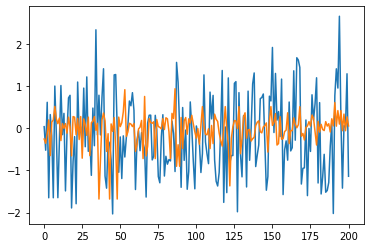

In [394]:
plt.figure();
vidx = 10
plt.plot(val_voxel_single_trial_data[:,vidx])
plt.plot(val_voxel_pred[:,vidx])